In [62]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from scipy.linalg import hadamard
from copy import deepcopy

n_samples = 2000
n_test = 100
k = 10
p = 50
rng = np.random.RandomState(0)

fit_loss = 'logreg'
reg = 'l1'

fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)


K = np.eye(p)
z_true = rng.randn(p, n_samples)
D = rng.randn(k, p).dot(K)
D /= np.linalg.norm(D, axis=0, keepdims=True)

sigma = 0.1
eps = rng.randn(k, n_samples)

z_test = rng.randn(p, n_test)
eps_test = rng.randn(k, n_test)
X = np.dot(D, z_true) + eps
X_test = np.dot(D, z_test) + eps_test
if fit_loss == 'logreg':
    X = 2 * (X > 0) - 1
    X_test = 2 * (X_test > 0) - 1
    
lbda_max = np.max(np.abs(D.T.dot(X)))
lbda = 0.1 * lbda_max
print(X.shape)

(10, 2000)


In [63]:
n_layers = 10000
ista_min = LISTA(D, lbda, n_layers, fit_loss, reg, variables='both', learn_levels=True, architecture='pgd')
# L = np.linalg.norm(D, ord=2) ** 2 * 10
# ista_min.levels = [lbda / L, ] *  n_layers 
f_min = ista_min.compute_loss(X_test)
z_hat = ista_min.transform(X_test)
L = np.linalg.norm(D, ord=2) ** 2
print(np.linalg.norm(z_hat - prox(z_hat - np.dot(D.T / L, der_function(np.dot(D, z_hat), X_test)), lbda / L)))
print(f_min)

9.92586007916918e-09
4.336997639018832


In [64]:
lista_init = LISTA(D, lbda, 1, fit_loss, reg, variables='both', learn_levels=False, architecture='cd')
lista_init.fit(X, l_rate=0.01, max_iter=1000, verbose=10, backtrack=True, thres=1e-6)
init_weights = deepcopy(lista_init.weights)

it 0, loss = 5.158e+00, grad_W = 3.09e-01, grad_l = 2.92e-01, l_rate = 1.00e-02
it 10, loss = 4.966e+00, grad_W = 6.47e-02, grad_l = 1.60e-01, l_rate = 1.02e+01
it 20, loss = 4.921e+00, grad_W = 1.94e-02, grad_l = 1.26e-01, l_rate = 1.02e+01
it 30, loss = 4.919e+00, grad_W = 1.38e-02, grad_l = 1.26e-01, l_rate = 5.12e+00
it 40, loss = 4.918e+00, grad_W = 1.26e-02, grad_l = 1.27e-01, l_rate = 2.56e+00
it 50, loss = 4.917e+00, grad_W = 1.39e-02, grad_l = 1.27e-01, l_rate = 2.56e+00
it 60, loss = 4.917e+00, grad_W = 1.35e-02, grad_l = 1.27e-01, l_rate = 2.56e+00
it 70, loss = 4.917e+00, grad_W = 1.19e-02, grad_l = 1.26e-01, l_rate = 2.56e+00


In [66]:
loss_untrained = []
loss_trained = []
layers = [1, 2, 3, 4, 8, 16]
l_rates = [1e-4, ] * len(layers)
for j, (l_rate, n_layers) in enumerate(zip(l_rates, layers)):
    print(n_layers)
    lista = LISTA(D, lbda, n_layers, fit_loss, reg, variables='both', learn_levels=False, architecture='cd')
    lista.weights[:2] = init_weights
    loss_untrained.append(lista.compute_loss(X_test))
    if j > 0:
        lista.weights[:len(old_weights)] = old_weights
        lista.levels[:len(old_levels)] = old_levels
    lista.fit(X, l_rate=l_rate, max_iter=201, verbose=100, backtrack=True, thres=0, l_rate_min=1e-6)
    old_weights = deepcopy(lista.weights)
    old_levels = deepcopy(lista.levels)
    loss_trained.append(lista.compute_loss(X_test))

1
it 0, loss = 4.917e+00, grad_W = 1.41e-02, grad_l = 1.25e-01, l_rate = 1.00e-04
it 100, loss = 4.916e+00, grad_W = 1.14e-02, grad_l = 1.28e-01, l_rate = 4.10e-01
it 200, loss = 4.915e+00, grad_W = 1.15e-02, grad_l = 1.26e-01, l_rate = 4.10e-01
2
it 0, loss = 4.757e+00, grad_W = 5.60e-02, grad_l = 6.86e-02, l_rate = 1.00e-04
it 100, loss = 4.704e+00, grad_W = 2.27e-02, grad_l = 1.10e-01, l_rate = 1.31e+01
it 200, loss = 4.698e+00, grad_W = 1.78e-02, grad_l = 1.12e-01, l_rate = 1.64e+00
3
it 0, loss = 4.624e+00, grad_W = 4.17e-02, grad_l = 6.18e-02, l_rate = 1.00e-04
it 100, loss = 4.592e+00, grad_W = 2.31e-02, grad_l = 9.22e-02, l_rate = 3.28e+00
it 200, loss = 4.586e+00, grad_W = 2.39e-02, grad_l = 8.98e-02, l_rate = 3.28e+00
4
it 0, loss = 4.546e+00, grad_W = 3.61e-02, grad_l = 4.94e-02, l_rate = 1.00e-04
it 100, loss = 4.529e+00, grad_W = 2.18e-02, grad_l = 7.37e-02, l_rate = 3.28e+00
it 200, loss = 4.526e+00, grad_W = 2.09e-02, grad_l = 7.36e-02, l_rate = 8.19e-01
8
it 0, loss = 4

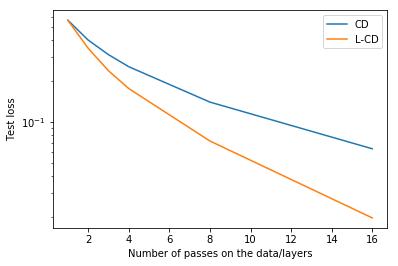

In [67]:
plt.plot(layers, loss_untrained - f_min, label='CD')
plt.plot(layers, loss_trained - f_min, label='L-CD')
plt.yscale('log')
plt.xlabel('Number of passes on the data/layers')
plt.ylabel('Test loss')
plt.savefig('fig_cd_%s_%s_%d_%d.pdf' % (fit_function, reg, k, p))
plt.legend()